# Spotify Self ~ Exploration ~

Using both [spotipy](https://spotipy.readthedocs.io/en/2.7.0/), built on top of the [Spotify Web API](https://developer.spotify.com/documentation/web-api/), we'll be creating our own rendition of Spotify's yearly summary :)) 

Throughout the notebook, we will be looking at several overarching questions:
  1. What kind of data does Spotify make avaliable?
  2. What are the musical differences between your peronal playlists, top songs and us top 50 playlists?
  3. What are the different music qualities amongst genres?
  4. At what time of day you listen to music the most?
  5. What kinds of music do you listen to at different times of day?

In [1]:
#your spotify username
username = "12157433086" #enter Spotify username here
my_playlist_name = 'chill' #this is one of my playlists, replace this with your own (I would recommend using Discover Weekly, if it is avaliable)

# Importing Packages

One of the reasons why Python is an extremely versatile language is due to the wide array of packages avaliable. 

These are some of the packages that we will be using within this notebook: 
1. `pandas`: the bread and butter package that you will get to know very well throughout this course
2. `seaborn`: simple, yet aesthetic data visualization
3. `plotly`: interactive data visualization (my personal favorite for viz)

Other notable packages are `numpy` (array manipulation) , `matplotlib` (data visualization), and `scikit-learn` (machine learning)

We will also be using the `spotipy` package, which is built on top of the Spotify Devleoper API, that will help us gather our personal data.

In [2]:
#installing packages
!pip install spotipy

#importing packages
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
from datetime import datetime
import matplotlib.pyplot as plt

import seaborn as sns
import plotly.express as px
import plotly as py
import plotly.graph_objs as go



# Data Collection

Now, we are going to need to collect our data. For the kaggle dataset, it is fairly easy to do, as we already have a csv file containing all the data.

First, we will need to mount our Google Drive. Run the cell below, and follow the link to authenticate the notebook to access your Drive files.

## Spotify API Extraction

Now, let's get set up the pipeline for our Spotify data. First, we will need to grant this notebook access. Running the function below, **click on the link that appears**. Then, after logging into your account and authenticating the notebook, you will be redirected to what appears to be Google BUT the URL will contain the redirect info, so **copy the URL from the Google page back into the textbox prompt**.



Below, you will see a whole bunch of functions that are prewrote to extract relevant data into manageable dataframes. You do NOT need to understand the functions, but feel free to come to my office hours to talk about them if you're curious about how they work!

In [3]:
# setting up spotipy api
import credentials

scope = 'user-top-read user-library-read playlist-modify-public playlist-read-private user-read-recently-played'

redirect_uri='https://127.0.0.1/callback'

client_credentials_manager = SpotifyClientCredentials(client_id=credentials.CLIENT_ID, client_secret=credentials.CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
token = util.prompt_for_user_token(username, scope, credentials.CLIENT_ID, credentials.CLIENT_SECRET, redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)


In [4]:
#getting all user playlists on Spotify (even private ones!)
playlists = sp.current_user_playlists().get("items")

#getting ids in playlists
playlist_ids = []
for playlist in playlists:
  playlist_ids.append(playlist.get("id"))
  print(playlist.get("name"))

Lofi Chill Christian Instrumental Worship Beats To Bible Study, Soak and Work To
Study Break
tril
krnb for self quarantine
Renewal Discography
ccm
chill
beats
~ korea ~
씁쓸하다
study music
frank
undocumented, rare
nostalgia, ultra
unreleased MISC
anime
holidays !
lofi hip hop music - beats to relax/study to
Lo-Fi Cafe


In [5]:
def get_playlist(user, playlist_id):
  """gets a user's playlist as an object

  Parameters
  ----------
  user: current Spotify user ID
  playlist_id: Spotify ID of playlist

  Returns
  -------
  playlist: playlist object
  """
  if playlist_id is None:
      playlist_id = raw_input('Playlist ID: ')
      
  playlist = sp.user_playlist(user, playlist_id, fields='tracks, name')
  return playlist

def all_playlist_tracks(playlist):
  """gets all tracks as objects within a playlist

  Parameters
  ----------
  playlist: playlist object

  Returns
  -------
  tracks: set of track objects
  """
  results = playlist['tracks']
  tracks = results['items']
  while results['next']:
      results = sp.next(results)
      tracks.extend(results['items'])
  return tracks

def get_playlist_name(playlist):
  """getting the name of the playlist

  Parameters
  ----------
  playlist: playlist object

  Returns
  -------
  name: playlist name
  """
  name = playlist['name']
  return name

def get_playlist_id_by_name(playlist_name):
  """getting tracks of playlist by its name

  Parameters
  ----------
  playlist_name: name of playlist

  Returns
  -------
  id: playlist id 
  """
  playlists = sp.current_user_playlists().get('items')
  for playlist in playlists:
    if playlist['name'] == playlist_name:
      return playlist['id']
  raise ValueError("playlist \"" + playlist_name + "\" not found!")

#get_audio_features
def get_audio_features_from_playlist(user, playlist_id):
  """getting audio features of playlist by playlist_id

  Parameters
  ----------
  user: current Spotify user ID
  playlist_id: Spotify ID of playlist

  Returns
  -------
  audio_df: dataframe containing audio features of each track in playlist
  """
  ids = []
  names = []
  afs = []
  playlist = get_playlist(user, playlist_id)
  if(playlist):
    playlist_name = get_playlist_name(playlist)
    tracks = all_playlist_tracks(playlist)
    for track in tracks:
        if(track):
          id = track['track']['id']
          name = track['track']['name'].encode('utf-8').decode()
          if id and name:
            audio_features = sp.audio_features(id)[0]
            if audio_features:
              audio_features['id'] = id;
              audio_features['name'] = name;
              afs.append(audio_features)
  audio_df = pd.DataFrame(afs)

  audio_df = audio_df[["name", "id", "acousticness", "danceability", "duration_ms", 
   "energy", "instrumentalness", "key", "liveness",
                          "loudness", "mode", "speechiness", "tempo", "valence"]]
  return audio_df


def get_audio_features_from_tracks(tracks):
  """getting audio features from a set of tracks

  Parameters
  ----------
  tracks: set of track objects

  Returns
  ------
  audio_df: dataframe containing audio features of each track
  """
  afs = []
  for track in tracks:
        if(track):
          id = track['id']
          name = track['name'].encode('utf-8').decode()
          if id and name:
            audio_features = sp.audio_features(id)[0]
            if audio_features:
              audio_features['id'] = id;
              audio_features['name'] = name;
              if('played_at' in track):
                audio_features['played_at'] = track['played_at'];
              afs.append(audio_features)
  audio_df = pd.DataFrame(afs)


  if 'played_at' in audio_df.columns:
    audio_df = audio_df[["name", "id", "played_at", "acousticness", "danceability", "duration_ms", 
   "energy", "instrumentalness", "key", "liveness",
                             "loudness", "mode", "speechiness", "tempo", "valence"]]
  else: 
    audio_df = audio_df[["name", "id", "acousticness", "danceability", "duration_ms", 
   "energy", "instrumentalness", "key", "liveness",
                             "loudness", "mode", "speechiness", "tempo", "valence"]]
  return audio_df


def get_genres_from_tracks(tracks):
  """getting genres of tracks 
    Note: Spotify associates each artist with a specific genre, so this method
          gets the artists for each track and then finds all relevant genres
          associated with the artists

  Parameters
  ----------
  tracks: set of track objects

  Returns
  ------
  genre_count: frequency list of genres associated with tracks
  """
  genre_count = {}
  for track in tracks:
      artists = track['artists']
      for artist in artists:
          artist_id = artist['id']
          if artist_id is not None:
              artist_obj = sp.artist(artist_id)
              genres = artist_obj['genres']
              for genre in genres:
                  if genre in genre_count:
                      genre_count[genre] = genre_count[genre] + 1;
                  else:
                      genre_count[genre] = 1;
  return genre_count  




def get_genres_from_playlist(user, playlist_id):
  """getting genres for a specific playlist

  Parameters
  ----------
  user: current Spotify user ID
  playlist_id: Spotify ID of playlist

  Returns
  ------
  genre_count: frequency list of genres associated with tracks
  """
  genre_count = {}
  playlist = get_playlist(user, playlist_id)
  tracks = all_playlist_tracks(playlist)
  for item in tracks:
      track = item['track']
      artists = track['artists']
      for artist in artists:
          artist_id = artist['id']
          if artist_id is not None:
              artist_obj = sp.artist(artist_id)
              genres = artist_obj['genres']
              for genre in genres:
                  if genre in genre_count:
                      genre_count[genre] = genre_count[genre] + 1;
                  else:
                      genre_count[genre] = 1;
  return genre_count      

def all_recent_playlist_tracks():
  """gets all recently played tracks

  Parameters
  ----------

  Returns
  -------
  tracks: set of track objects
  """
  tracks = []
  results = sp.current_user_recently_played(limit=50)
  temp_tracks = results['items']
  while results['next']:
      results = sp.next(results)
      temp_tracks.extend(results['items'])
  for track in temp_tracks:
    to_append = track['track']
    to_append['played_at'] = track['played_at']
    tracks.append(to_append)
  return tracks 

## Getting Dataframes

In [6]:
#discover weekly
play_tracks = get_playlist_id_by_name(my_playlist_name)
play_df = get_audio_features_from_playlist(username, play_tracks)
#top tracks
top_tracks = sp.current_user_top_tracks().get("items")
top_tracks_df = get_audio_features_from_tracks(top_tracks)
#us_50
us_top_50 = "37i9dQZEVXbLRQDuF5jeBp" #playlist id
top_50_df = get_audio_features_from_playlist("spotify", us_top_50)

#recently_played_df
recently_played = all_recent_playlist_tracks()
recently_played_df = get_audio_features_from_tracks(recently_played)

In [7]:
#creating our genres_df

#Discover Weekly Playlist
genres_play = get_genres_from_playlist(username, play_tracks)
genres_play_df = pd.DataFrame(genres_play.items())

#Tracks Playlist
genres = get_genres_from_tracks(top_tracks)
genres_top_df = pd.DataFrame(genres.items())

#Top 50 playlist
genres_top_50 = get_genres_from_playlist(username, us_top_50)
genres_top_50_df = pd.DataFrame(genres_top_50.items())

genres_play_df.columns = ['genre', 'number']
genres_top_df.columns = ['genre', 'number']
genres_top_50_df.columns = ['genre', 'number']

genres_play_df['playlist'] = my_playlist_name
genres_top_df['playlist'] = "Top Tracks"
genres_top_50_df['playlist'] = "Top 50 Tracks"

genres_df = genres_top_df.append(genres_play_df)


# Data Exploration

At this point we should have the following datasets:

- `play_df`: audio features within your discover weekly playlist or personal playlist of interest 
- `top_tracks_df`: audio features in your current top tracks playlist
- `top_50_df`: audio features us top-50 playlist
- `recently_played_df`: contains an additional "played_at" column that has the time at which we played our music
- `genres_df`: aggregate of genres avaliable in each playlist

Now that we collected our data, we need to know what information actually avaliable within our dataset. Here we will cover the following:

- Previewing data
- Summary functions



### 1. Previewing data

data.head() is the easiest and quickest way to see a glimpse of our data without getting overwhelmed. This function returns the first couple of rows in our dataset. Let's call this on our `kaggle_df`, `play_df` and `recently_played_df` dataframes. What do you see?

In [8]:
play_df.head()

,name,id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
0,YEAH RIGHT,1VGzxJnVQND7Cg5H5wGj14,0.61900,0.672,174358,0.588,0.241000,1,0.0992,-9.573,1,0.1330,169.033,0.204
1,Yellow,3AJwUDP919kvQ9QcozQPxg,0.00239,0.429,266773,0.661,0.000130,11,0.2340,-7.227,1,0.0281,173.365,0.285
2,Butterflies,6kVku2CoE7fbD29miiutzw,0.30700,0.540,199184,0.744,0.000089,1,0.1030,-10.942,1,0.4050,92.207,0.925
3,So Mean,67LVRpGwukS1vEO8nNzT37,0.84400,0.606,270446,0.685,0.000028,7,0.3750,-6.224,1,0.2640,84.645,0.723
4,Almost (Sweet Music),5Apvsk0suoivI1H8CmBglv,0.02150,0.523,217480,0.687,0.000003,7,0.2030,-5.601,1,0.1050,90.036,0.711


In [9]:
recently_played_df.head()

,name,id,played_at,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
0,Float On,6rJUWBi2vx7eIH9xpWLlnw,2020-05-02T07:04:01.590Z,0.97700,0.417,196800,0.0737,0.000157,2,0.114,-20.099,0,0.0330,149.991,0.1850
1,Painkiller,1abFkY2jm6KDFMZ7RD9YJh,2020-05-02T07:00:44.349Z,0.10500,0.675,213598,0.4140,0.000000,5,0.192,-6.508,1,0.0569,128.927,0.4390
2,Changes,7cDpMO5wuWgvv3j4INRBeB,2020-05-02T06:57:02.464Z,0.45200,0.532,160187,0.4550,0.000000,2,0.237,-8.366,1,0.1560,148.182,0.2040
3,Nothing Compares - Bonus Track,5ciyqWW5YuGqF4Avu7uwry,2020-05-02T06:54:21.729Z,0.00253,0.524,222307,0.5770,0.044300,1,0.234,-9.313,1,0.0358,131.909,0.0398
4,hungover sunday,3jGlOBjMJiNDWhdqRJl5dK,2020-05-02T06:50:38.964Z,0.85300,0.673,180403,0.3270,0.000000,2,0.103,-7.670,1,0.0827,82.729,0.4490


# Data Manipulation

In the following section, we will learn how to merge/manipulate datasets. We will be primarily using the personal data we extracted using Spotify's API.

1. Adding columns
2. Sorting by a column(s)
2. Append vs. Merge
4. Aggregation
5. Apply a function to a column
6. Filtering

### 1. Adding New Columns 

We can add new columns by using the following syntax:

df[**new column name**] = **column values**


Let's add a column `playlist` to each of our Spotify dfs with one value that contains the name of the playlist.

In [10]:
play_df['playlist'] = my_playlist_name
top_tracks_df['playlist'] = 'Top Tracks'
top_50_df['playlist'] = 'Top US Tracks'
recently_played_df['playlist'] = 'Recently Played'

### 2. Sorting by column(s)

Sometimes, we want to sort our dataframe by a specific column. We can apply the `sort_values` function and pass in the column(s) we want to sort by. This function also contains an `ascending` parameter, which is by default set to False. 

Let's apply this function to our `recently_played_df` and sort by `played_at` to see the most distant songs played (what should we set `ascending` to?)


In [11]:
recently_played_df.sort_values(by=['played_at'], ascending=True).head()

,name,id,played_at,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,playlist
46,ily (i love you baby) (feat. Emilee),62aP9fBQKYKxi7PDXwcUAS,2020-05-01T21:37:54.167Z,0.0686,0.674,176547,0.774,0.001880,11,0.3930,-7.567,0,0.0892,112.050,0.330,Recently Played
45,Call Me Up,49VevNdsb5zvMFfZMVrCJi,2020-05-01T21:41:08.312Z,0.6440,0.821,164000,0.341,0.000000,2,0.3560,-10.086,1,0.1240,92.027,0.426,Recently Played
44,Think About' Chu,3e0VhBdgJLUhI1ErcrY64B,2020-05-01T21:45:08.511Z,0.2250,0.779,239837,0.559,0.000000,11,0.0924,-6.282,1,0.0778,85.005,0.900,Recently Played
43,Stuck On You,4tmyQGiQ8SjfrLXyjFrAoL,2020-05-01T21:48:21.280Z,0.8850,0.733,192133,0.405,0.000132,10,0.1160,-8.390,1,0.0454,95.086,0.361,Recently Played
42,Forever Always,1bFeQVE1JjJFLH3HrGIU3Y,2020-05-01T21:51:57.141Z,0.8230,0.385,215427,0.372,0.000019,0,0.1520,-9.266,0,0.0879,77.010,0.484,Recently Played


### 3. Append vs. Merge


Both of these functions are used in order to combine two different data frames. 

**Append** is used to add the rows of one data frame to another
**Merge** is used to join two dataframes by like values in specified columns 

In [12]:
#appending dataframes 

#compiling all our Spotify dataframes into one
personal_df = play_df.copy()
personal_df = personal_df.append(top_tracks_df)
personal_df = personal_df.append(top_50_df)

In [16]:
#merging data frames

#how many of my top songs appear on the us top 50 list?
top_tracks_df.merge(top_50_df, how='inner', on='id')

,name_x,id,acousticness_x,danceability_x,duration_ms_x,energy_x,instrumentalness_x,key_x,liveness_x,loudness_x,...,energy_y,instrumentalness_y,key_y,liveness_y,loudness_y,mode_y,speechiness_y,tempo_y,valence_y,playlist_y


### 4. Aggregation

In order to get a broader picture of our data, we often want to aggregate values with classic summary statistics such as mean, median, and count. 

This is especially important when we want to compare different groups within our data. Now that we have an `personal_df` that consists of all our individual playlist data, an interesting metric to look at would be whether or not there are noticeable differences amongst our seperate playlists.

In order to do this in pandas, we must first call the `groupby()` function and specify the group we want to aggregate on (in this case `playlist`) and then call the specific summary statistic function. 

For example, if we wanted to find the mean of each group we would do the following:

df.group_by(group).mean()

Let's create two new dfs, `agg_personal_df` and `agg_kaggle_df` to get group by `playlist` and `genre` respectively and summarise by `mean()`

In [17]:
agg_personal_df = personal_df.groupby('playlist').mean()
agg_personal_df = agg_personal_df.reset_index()

### 5. Apply 

Below, we have defined the `get_played_hour` function to extract the hour from the timestamp formula specified by Spotify. This function utilizes the `datetime` package to parse the date format (this will be helpful for HW1!)

Let's use `apply()` on our `recently_played_df` to find the hour at which we played a song. 

Note: `apply()` takes in an `axis` parameter which details axis to apply the function on. `axis=0` will act on all rows in each column, while `axis=1` will act on all columns in each row. Which one's appropriate for this task? 


In [18]:
def get_played_hour(row):
    """gets the hour the recently played song was played at
    dataset must have a played_at column

    Parameters
    ----------
    row: row to apply on, dataframe must have a "played_at" column

    Returns
    -------
    tracks: set of track objects
    """
    played_time = row['played_at']
    if ("." in played_time):
      played_time = played_time.split(".")[0]
    else:
      played_time = played_time.split("Z")[0]
    played_time_parsed = datetime.strptime(played_time, '%Y-%m-%dT%H:%M:%S')
    return played_time_parsed.hour

In [19]:
recently_played_df['hour_played'] = recently_played_df.apply(get_played_hour,axis=1)

In [20]:
pivot_agg_personal_df = pd.melt(agg_personal_df, id_vars =['playlist'], value_vars =["acousticness",	"danceability",	"energy", "liveness","speechiness"])
pivot_agg_personal_df.columns = ["playlist", "feature", "value"] #renaming columns

pivot_personal_df = pd.melt(personal_df, id_vars =['playlist'], value_vars =["acousticness",	"danceability",	"energy", "liveness","speechiness"])
pivot_personal_df.columns = ["playlist", "feature", "value"] #renaming columns

### Final Datasets:

After all that wrangling, we have ended up with the follow datasets:


**Spotify Datasets:**
1. `personal_df`: an aggregation of all our datasets from Spotify, which include
    - `play_df`
    - `top_tracks_df`
    - `top_50_df`
2. `agg_personal_df`: contains the mean values for all of the audio feature metrics released by spotify
3. `recently_played_df`: df with the audio features of all our recently played music

**Pivot Datsets**
1. `pivot_agg_personal_df`: a pivoted version of the aggregate personal dataset
2. `pivot_agg_kaggle_df`: a pivoted version of the aggregate kaggle dataset

# Data Visualization

Now, that we have sufficiently explored our data, let's start creating some visualizations!. We will specifically be using `seaborn` and `plotly`.

- [seaborn](https://seaborn.pydata.org/) creates relatively aesthetic visualizatons with minimal effort. I like using seaborn for simple, yet informative graphs like barplots, boxplots and line charts and. since the syntax is very straightforward and easy to underst
- [plotly](https://plot.ly/python/) is personally my favorite Python visualization tool as it creates *interactive* visualizations. There are many predefined graph templates avaliable on the website that can be used to create complex visualizations.

Throughout this section, remember the following data visualization steps:

1. Look at your data
2. Identify the message and its components
3. Select your chart 
4. Refine

## Data Visualization with Seaborn

Using seaborn, let's answer some simple questions:

1. What is the most common key within our personal playlist?
2. How do the `danceability` scores compare amongst our personal playlist, top songs, and top 50 us songs?

### 1. What is the most common key within our personal playlist?

To answer this question, the most fitting graph would be a countplot. Let's use `play_df`, let's make a countplot of the column `key`. 

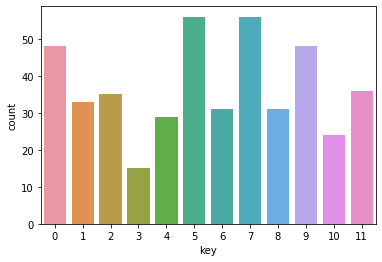

In [21]:
#count plot
sns.countplot(x="key", data=play_df)

Pretty simple right? Now, we can see the counts of each key within out playlist. However, because Spotify stores the values as numbers, it's not very clear what key maps to what. Additionally, the columns are not in any sort of order, so its not immediately apparent which key is the most frequent within our playlist. 

To fix these issues, we will first map the values within our `play_df` to their actual letter. We will also utilize the `order` parameter avaliable within the `sns.countplot` function to order the bars in descending order.

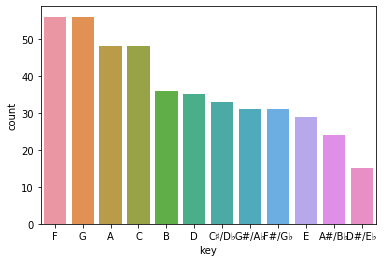

In [22]:
#dictionary
key_dict = {0: "C", 1 :"C♯/D♭", 2:"D", 3:"D#/E♭", 4:"E", 5:"F", 6:"F#/G♭",7:"G",8:"G#/A♭",9:"A",10:"A#/B♭",11:"B"}
#replacting values
play_df["key"] = play_df["key"].replace(key_dict)

#replotting the graph
sns.countplot(x="key", data=play_df, order= play_df["key"].value_counts().index)


### 2. How do the `danceability` scores compare amongst our personal playlist, top songs, and top 50 us songs?

Because `danceability` is a quantitative variable, it will have numeric properties that relate to its distribution (mean, median, spread, etc.) Thus, things like scatter plots, box plots would be great ways to look at the data.

Another effective plot would be a violin plot, which overlays the shape of the overall distribution on top of a standard boxplot. 

Using the `personal_df` dataframe that contains all of our data from spotify, let's compare danceability scores:


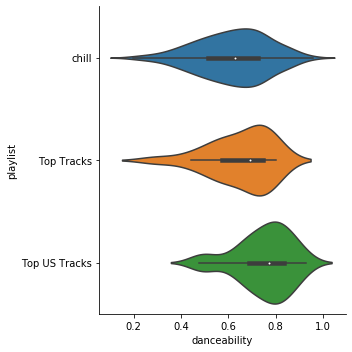

In [23]:
 #violin plot
sns.catplot(x="danceability",y="playlist", kind="violin",data=personal_df)

## Data Visualization with Plotly

With plotly, let's try to create more layered and complex graphs. These can also be created in seaborn, but plotly's biggest advantages is that you can interact with the graphs in various ways including zooming, isolating variables, and hovering tool tips. This means that you can afford to iniitally create more complicated visuals as you will have the opportunity to interact and adjust the graph later on.


###1. Grouped Bar Plots 

One way to "spice" up visualizations is using color to further categorize information. Let's take advantage of this to compare the different types of genres within our playlists.

In [24]:
tips = px.data.tips()
fig = px.bar(genres_df, x='genre', y='number', color="playlist")
fig.show()

### 2. 3D Scatter Plots

plotly has a ton of interesting visualization tools, but just because they are interesting, doesn't mean that they are actually meaningful. Would you argue that the 3D scatter plot below is a helpful visual?

In [25]:
px.scatter_3d(personal_df, x='energy', y="danceability", z="speechiness", color = 'playlist', template='plotly_dark' )

### 3. Side-by-Side Violin Plot

We can manipulate our classic violin plot into a side-by-side violin plot to compare distributions of audio features across different playlists. What are the pros of this visualization? Cons?

In [26]:
#violin plot
fig = go.Figure()

df = pivot_personal_df
fig.add_trace(go.Violin(x=df['feature'][ df['playlist'] == my_playlist_name ],
                        y=df['value'][ df['playlist'] == my_playlist_name ],
                        legendgroup=my_playlist_name, scalegroup=my_playlist_name, name=my_playlist_name,
                        side='negative',
                        line_color='blue')
             )
fig.add_trace(go.Violin(x=df['feature'][ df['playlist'] == 'Top US Tracks' ],
                        y=df['value'][ df['playlist'] == 'Top US Tracks' ],
                        legendgroup='Top US Tracks', scalegroup='Top US Tracks', name='Top US Tracks',
                        side='positive',
                        line_color='orange')
             )
fig.update_traces(meanline_visible=True)
fig.update_layout(violingap=0, violinmode='overlay')
fig.show()

### 4. Radial Plots

Radial plots, or spider plots is another way to visualize the magnitudes of data. What are the pros of this visualization? Cons?

In [27]:
#radial plot
fig = px.line_polar(pivot_agg_personal_df, r="value", theta="feature", color="playlist", line_close=True, color_discrete_sequence=["red", "orange", "skyblue"])
fig.show()

### 5. Time Series Data - Layering Metrics

When dealing with time series data, we always want to look at trends overtime for different parameters. One effect means of doing this is having multiple axes per graph and placing different parameters on the same graph to see if there are any correlated trends.

In [31]:
recently_played_freq = recently_played_df.groupby('hour_played').count().reset_index()
recently_played_mean = recently_played_df.groupby('hour_played').mean().reset_index()

In [32]:

trace1 = go.Bar(
    x=recently_played_freq['hour_played'],
    y=recently_played_freq['danceability'],
    name='frequency'
)
trace2 = go.Scatter(
    x=recently_played_mean['hour_played'],
    y=recently_played_mean['danceability'],
    name='danceability',
    yaxis='y2'
)
data = [trace1, trace2]
layout = go.Layout(
    title='Frequency and Danceability per Time of Day',
    yaxis=dict(
        title='frequency'
    ),
    yaxis2=dict(
        title='danceability',
        titlefont=dict(
            color='rgb(148, 103, 189)'
        ),
        tickfont=dict(
            color='rgb(148, 103, 189)'
        ),
        overlaying='y',
        side='right'
    ),
    template="plotly_white"
)

go.Figure(data=data, layout=layout)